<a href="https://colab.research.google.com/github/nafis-neehal/ML_PROJ_RPI/blob/main/HW5/HW5_1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1c: Data Augmented Training for CIFAR10 Dataset Classification
In this task, I have augmented CIFAR10 dataset by introducing diversity like Random Rotations and Random Horizontal Flips. Then I have tried to classify this augmented dataset with the same CNN model from part 1a by retraining. 

Dataset: Cifar10 https://pytorch.org/vision/stable/datasets.html \\
Cifar10 Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tqdm import tqdm 
import time, copy
import pickle
import seaborn as sns

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, tf.test.gpu_device_name())

cuda:0 /device:GPU:0


Here I have used simple transformations on the whole data - resized them by upsampling, then croped in the center, transformed them into tensor and then normalized the data. I upsampled the data because MobileNet requires data input size of 224x224. \\
I have then created three separate dataloaders for Train, Validation and Test batches with batch size 4 because of GPU memory issues. \\
I have used CIFAR10 image dataset for this problem. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. We have used validation size of 10% of the training set.

In [ ]:
transform = transforms.Compose(
    [
     transforms.RandomRotation((15,30)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

batch_size = 128

train    = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

validation_size = int(train.data.shape[0] * 0.10)
train_size = int(train.data.shape[0] - validation_size)

trainset, validset = torch.utils.data.random_split(train, [train_size,validation_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(validset, batch_size=len(validset), shuffle=True, num_workers=4)

testset     = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader  =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Some augmented training datasets

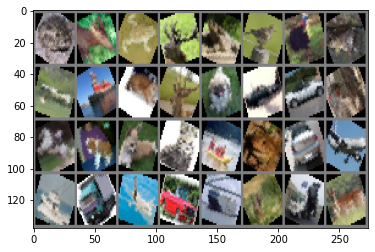

In [ ]:
def imgshow(img):
  img = img/2 + 0.5 
  numpy_img = img.numpy()
  plt.imshow(np.transpose(numpy_img,(1,2,0)), aspect='auto')
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imgshow(torchvision.utils.make_grid(images[:32], nrow=8))

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 5, padding="same")   
    self.pool  = nn.MaxPool2d(2, 2)         
    self.drop  = nn.Dropout(0.2)             
    self.conv2 = nn.Conv2d(16, 64, 5, padding="same")  
    self.fc1   = nn.Linear(64*8*8, 256)
    self.fc2   = nn.Linear(256, 64)
    self.fc3   = nn.Linear(64, 10) 

  def forward(self, x):
    x = self.conv1(x)         #output 32x32x6
    x = F.relu(x)             #output 32x32x6
    x = self.pool(x)          #output 16x16x6
    x = self.conv2(x)         #output 16x16x16
    x = F.relu(x)             #output 16x16x16
    x = self.pool(x)          #output 8x8x16
    x = torch.flatten(x, 1)   #flatten all dimension except batch
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = ConvNet()
model.to(device)
model

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

We perform the training with 20 epochs. Everytime we train on one batch, we measure the validation score and keep tabs on both losses and accuracies for training and validation. After each 50 iterations of batches, we check the running average of accuracies and losses and if the model improves on validation set, we then save the model state as the current best model state. After the whole training is done, we reload the saved best model state and evaluate that on training set. We finally then save model history, model best state offline for future use. 

In [ ]:
#args = model path, history path
def train_or_load(model, perform, *args):

  if perform=="train":

    best_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0 
    stat_in_each_batch = 50
    EPOCHS = 20

    tr_acc_hist   = []
    tr_loss_hist  = []
    val_loss_hist = []
    val_acc_hist  = []

    since = time.time()

    for epoch in range(EPOCHS):  # loop over the dataset multiple times

        tr_running_loss = 0.0
        tr_running_corr = 0

        for i, data in tqdm(enumerate(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            tr_inputs, tr_labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            tr_outputs = model(tr_inputs)
            loss = criterion(tr_outputs, tr_labels)
            loss.backward()
            optimizer.step()

            # print statistics
            tr_running_loss += loss.item() * tr_inputs.size(0)
            _, tr_preds = torch.max(tr_outputs, 1)
            tr_running_corr += torch.sum(tr_preds==tr_labels.data)

            # #gpu memory clean
            tr_inputs.detach()
            tr_labels.detach()
            tr_outputs.detach()

            if (i+1) % stat_in_each_batch == 0:
              with torch.no_grad():
                v_loss = 0.0
                v_corr = 0
                for j, data in enumerate(validloader):
                  v_inputs, v_labels = data[0].to(device), data[1].to(device)
                  v_outputs = model(v_inputs)
                  loss = criterion(v_outputs, v_labels)

                  _, v_preds = torch.max(v_outputs, 1)
                  v_loss += loss.item() * v_inputs.size(0)
                  v_corr += torch.sum(v_preds==v_labels.data)
              
              #placeholder
              val_acc   = v_corr/len(validloader.dataset)
              tr_acc    = tr_running_corr / (stat_in_each_batch*batch_size) 
              val_loss  = v_loss/len(validloader.dataset)
              tr_loss   = tr_running_loss/(stat_in_each_batch*batch_size)

              #print stat
              print(f"\n Epoch: {epoch} Batch: {(i+1)} Train Loss: {tr_loss} Train Acc: {tr_acc} Val Loss: {val_loss} Val Acc: {val_acc}")
              
              #make sum 0
              tr_running_loss = 0.0
              tr_running_corr = 0

              #save history
              tr_acc_hist.append(tr_acc)
              tr_loss_hist.append(tr_loss)
              val_loss_hist.append(val_loss)
              val_acc_hist.append(val_acc)

              #model state transfer
              if val_acc > best_val_acc:
                best_val_acc = val_acc 
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_val_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    #history
    tr_acc_hist = [x.cpu().item() for x in tr_acc_hist]
    val_acc_hist = [x.cpu().item() for x in val_acc_hist] 
    history = {"Training Loss": tr_loss_hist, "Training Accuracy": tr_acc_hist, "Validation Loss": val_loss_hist, "Validation Accuracy": val_acc_hist}

    #save model
    torch.save(model.state_dict(), args[0])

    #save history
    with open(args[1], 'wb') as f:
      pickle.dump(history, f)


  elif perform=="load":
    PATH = args[0]
    model.load_state_dict(torch.load(PATH))

    with open(args[1], 'rb') as f:
      history = pickle.load(f)

  return model, history





In [ ]:
#model path
model_PATH = './drive/MyDrive/ML Project Course/HW5/cifar_net_aug.pth'
history_PATH = "./drive/MyDrive/ML Project Course/HW5/history_5_1c.pkl"

In [ ]:
model, history = train_or_load(model, "train", *[model_PATH, history_PATH])

51it [00:03,  5.00it/s]


 Epoch: 0 Batch: 50 Train Loss: 2.302790675163269 Train Acc: 0.10703124850988388 Val Loss: 2.3021812438964844 Val Acc: 0.12139999866485596


110it [00:07,  9.25it/s]


 Epoch: 0 Batch: 100 Train Loss: 2.301432309150696 Train Acc: 0.12859374284744263 Val Loss: 2.300366163253784 Val Acc: 0.1436000019311905


158it [00:10,  9.24it/s]


 Epoch: 0 Batch: 150 Train Loss: 2.2996096324920656 Train Acc: 0.14781250059604645 Val Loss: 2.298260450363159 Val Acc: 0.14999999105930328


206it [00:14,  8.06it/s]


 Epoch: 0 Batch: 200 Train Loss: 2.296980142593384 Train Acc: 0.15390624105930328 Val Loss: 2.296492099761963 Val Acc: 0.16040000319480896


259it [00:18,  8.87it/s]


 Epoch: 0 Batch: 250 Train Loss: 2.2954681396484373 Train Acc: 0.16953124105930328 Val Loss: 2.2936627864837646 Val Acc: 0.1703999936580658


306it [00:21,  8.15it/s]


 Epoch: 0 Batch: 300 Train Loss: 2.2925864458084106 Train Acc: 0.18124999105930328 Val Loss: 2.2902297973632812 Val Acc: 0.19059999287128448


352it [00:24, 14.11it/s]


 Epoch: 0 Batch: 350 Train Loss: 2.2880547142028806 Train Acc: 0.1942187398672104 Val Loss: 2.2862555980682373 Val Acc: 0.1817999929189682



57it [00:03,  8.90it/s]


 Epoch: 1 Batch: 50 Train Loss: 2.2837441301345827 Train Acc: 0.19171874225139618 Val Loss: 2.2801871299743652 Val Acc: 0.19679999351501465


109it [00:07,  9.37it/s]


 Epoch: 1 Batch: 100 Train Loss: 2.2768599605560302 Train Acc: 0.19984374940395355 Val Loss: 2.2714638710021973 Val Acc: 0.20419999957084656


161it [00:11,  9.16it/s]


 Epoch: 1 Batch: 150 Train Loss: 2.2659426879882814 Train Acc: 0.20156249403953552 Val Loss: 2.258861541748047 Val Acc: 0.20099999010562897


209it [00:14,  8.89it/s]


 Epoch: 1 Batch: 200 Train Loss: 2.2514947175979616 Train Acc: 0.19874998927116394 Val Loss: 2.238111972808838 Val Acc: 0.21660000085830688


259it [00:18,  7.95it/s]


 Epoch: 1 Batch: 250 Train Loss: 2.228589668273926 Train Acc: 0.2084375023841858 Val Loss: 2.2106714248657227 Val Acc: 0.21639999747276306


307it [00:21,  8.96it/s]


 Epoch: 1 Batch: 300 Train Loss: 2.196136374473572 Train Acc: 0.2110937386751175 Val Loss: 2.1697604656219482 Val Acc: 0.22439999878406525


352it [00:24, 14.10it/s]


 Epoch: 1 Batch: 350 Train Loss: 2.152239327430725 Train Acc: 0.22499999403953552 Val Loss: 2.121568441390991 Val Acc: 0.24300000071525574



59it [00:03,  8.45it/s]


 Epoch: 2 Batch: 50 Train Loss: 2.1125395679473877 Train Acc: 0.22999998927116394 Val Loss: 2.0752596855163574 Val Acc: 0.2401999980211258


109it [00:07,  8.39it/s]


 Epoch: 2 Batch: 100 Train Loss: 2.065751588344574 Train Acc: 0.24124999344348907 Val Loss: 2.0419814586639404 Val Acc: 0.2457999885082245


159it [00:10,  8.27it/s]


 Epoch: 2 Batch: 150 Train Loss: 2.038517279624939 Train Acc: 0.2556249797344208 Val Loss: 2.008423328399658 Val Acc: 0.25599998235702515


207it [00:14,  8.85it/s]


 Epoch: 2 Batch: 200 Train Loss: 2.014271538257599 Train Acc: 0.2620312571525574 Val Loss: 1.9997867345809937 Val Acc: 0.2572000026702881


259it [00:17,  9.39it/s]


 Epoch: 2 Batch: 250 Train Loss: 1.9965936398506166 Train Acc: 0.265625 Val Loss: 1.9748234748840332 Val Acc: 0.29339998960494995


310it [00:21,  9.14it/s]


 Epoch: 2 Batch: 300 Train Loss: 1.9816264152526855 Train Acc: 0.26374998688697815 Val Loss: 1.967367172241211 Val Acc: 0.27399998903274536


352it [00:24, 14.22it/s]


 Epoch: 2 Batch: 350 Train Loss: 1.963195812702179 Train Acc: 0.2879687547683716 Val Loss: 1.9563006162643433 Val Acc: 0.2879999876022339



57it [00:03,  8.91it/s]


 Epoch: 3 Batch: 50 Train Loss: 1.9506603407859802 Train Acc: 0.28437498211860657 Val Loss: 1.935569167137146 Val Acc: 0.29179999232292175


111it [00:07,  9.85it/s]


 Epoch: 3 Batch: 100 Train Loss: 1.9550665068626403 Train Acc: 0.29093748331069946 Val Loss: 1.9286097288131714 Val Acc: 0.2897999882698059


157it [00:10,  8.32it/s]


 Epoch: 3 Batch: 150 Train Loss: 1.9301259708404541 Train Acc: 0.29390624165534973 Val Loss: 1.9115289449691772 Val Acc: 0.3139999806880951


210it [00:14,  9.56it/s]


 Epoch: 3 Batch: 200 Train Loss: 1.9016270160675048 Train Acc: 0.3103124797344208 Val Loss: 1.8898632526397705 Val Acc: 0.3222000002861023


259it [00:18,  8.34it/s]


 Epoch: 3 Batch: 250 Train Loss: 1.908731508255005 Train Acc: 0.31734374165534973 Val Loss: 1.8787550926208496 Val Acc: 0.3149999976158142


306it [00:21,  8.17it/s]


 Epoch: 3 Batch: 300 Train Loss: 1.8781694316864013 Train Acc: 0.3153125047683716 Val Loss: 1.8574556112289429 Val Acc: 0.33159998059272766


352it [00:25, 14.02it/s]


 Epoch: 3 Batch: 350 Train Loss: 1.8868499684333802 Train Acc: 0.3192187547683716 Val Loss: 1.8534435033798218 Val Acc: 0.33159998059272766



57it [00:03,  8.89it/s]


 Epoch: 4 Batch: 50 Train Loss: 1.8772175049781799 Train Acc: 0.3176562488079071 Val Loss: 1.8375846147537231 Val Acc: 0.337799996137619


107it [00:07,  8.53it/s]


 Epoch: 4 Batch: 100 Train Loss: 1.8393205690383911 Train Acc: 0.3257812559604645 Val Loss: 1.819411277770996 Val Acc: 0.34219998121261597


159it [00:11,  8.74it/s]


 Epoch: 4 Batch: 150 Train Loss: 1.831142463684082 Train Acc: 0.34453123807907104 Val Loss: 1.802564263343811 Val Acc: 0.34939998388290405


210it [00:14,  9.02it/s]


 Epoch: 4 Batch: 200 Train Loss: 1.7929305028915405 Train Acc: 0.3506249785423279 Val Loss: 1.7845267057418823 Val Acc: 0.3547999858856201


260it [00:18,  9.85it/s]


 Epoch: 4 Batch: 250 Train Loss: 1.8309170126914978 Train Acc: 0.32749998569488525 Val Loss: 1.7908109426498413 Val Acc: 0.3455999791622162


309it [00:21,  9.21it/s]


 Epoch: 4 Batch: 300 Train Loss: 1.8104360222816467 Train Acc: 0.33781248331069946 Val Loss: 1.7778770923614502 Val Acc: 0.3479999899864197


352it [00:24, 14.08it/s]


 Epoch: 4 Batch: 350 Train Loss: 1.7817750811576842 Train Acc: 0.35624998807907104 Val Loss: 1.753798246383667 Val Acc: 0.36879998445510864



58it [00:03,  8.97it/s]


 Epoch: 5 Batch: 50 Train Loss: 1.765626721382141 Train Acc: 0.3631249964237213 Val Loss: 1.7403990030288696 Val Acc: 0.3734000027179718


109it [00:07,  8.45it/s]


 Epoch: 5 Batch: 100 Train Loss: 1.7677192974090576 Train Acc: 0.3621875047683716 Val Loss: 1.7348473072052002 Val Acc: 0.37219998240470886


160it [00:11,  9.14it/s]


 Epoch: 5 Batch: 150 Train Loss: 1.7560630345344543 Train Acc: 0.3551562428474426 Val Loss: 1.7369292974472046 Val Acc: 0.3716000020503998


208it [00:14,  9.17it/s]


 Epoch: 5 Batch: 200 Train Loss: 1.732035059928894 Train Acc: 0.3790625035762787 Val Loss: 1.7160853147506714 Val Acc: 0.3797999918460846


259it [00:18,  8.71it/s]


 Epoch: 5 Batch: 250 Train Loss: 1.7515902614593506 Train Acc: 0.3620312511920929 Val Loss: 1.710343360900879 Val Acc: 0.3807999789714813


309it [00:21,  8.65it/s]


 Epoch: 5 Batch: 300 Train Loss: 1.7392367792129517 Train Acc: 0.3634375035762787 Val Loss: 1.7041468620300293 Val Acc: 0.38259997963905334


352it [00:25, 14.03it/s]


 Epoch: 5 Batch: 350 Train Loss: 1.725556230545044 Train Acc: 0.37312498688697815 Val Loss: 1.6884980201721191 Val Acc: 0.3871999979019165



58it [00:03,  9.65it/s]


 Epoch: 6 Batch: 50 Train Loss: 1.7155116319656372 Train Acc: 0.3760937452316284 Val Loss: 1.6741572618484497 Val Acc: 0.3937999904155731


108it [00:07,  9.16it/s]


 Epoch: 6 Batch: 100 Train Loss: 1.7099389982223512 Train Acc: 0.3854687511920929 Val Loss: 1.6718382835388184 Val Acc: 0.40139999985694885


159it [00:11,  9.17it/s]


 Epoch: 6 Batch: 150 Train Loss: 1.689462125301361 Train Acc: 0.3826562464237213 Val Loss: 1.6815353631973267 Val Acc: 0.39579999446868896


210it [00:14,  8.80it/s]


 Epoch: 6 Batch: 200 Train Loss: 1.6747666025161743 Train Acc: 0.39640623331069946 Val Loss: 1.6590009927749634 Val Acc: 0.3999999761581421


258it [00:18,  9.24it/s]


 Epoch: 6 Batch: 250 Train Loss: 1.6756355834007264 Train Acc: 0.38328123092651367 Val Loss: 1.6571681499481201 Val Acc: 0.4027999937534332


306it [00:21,  7.83it/s]


 Epoch: 6 Batch: 300 Train Loss: 1.6625368976593018 Train Acc: 0.39921873807907104 Val Loss: 1.651180624961853 Val Acc: 0.40619999170303345


352it [00:25, 13.96it/s]


 Epoch: 6 Batch: 350 Train Loss: 1.66677081823349 Train Acc: 0.39281249046325684 Val Loss: 1.6499230861663818 Val Acc: 0.39899998903274536



59it [00:03,  8.81it/s]


 Epoch: 7 Batch: 50 Train Loss: 1.6638683581352234 Train Acc: 0.3959375023841858 Val Loss: 1.6343311071395874 Val Acc: 0.4081999957561493


110it [00:07,  8.95it/s]


 Epoch: 7 Batch: 100 Train Loss: 1.6381085062026977 Train Acc: 0.4090625047683716 Val Loss: 1.6244310140609741 Val Acc: 0.41579997539520264


156it [00:10,  8.14it/s]


 Epoch: 7 Batch: 150 Train Loss: 1.6478084588050843 Train Acc: 0.40437498688697815 Val Loss: 1.625921368598938 Val Acc: 0.41519999504089355


210it [00:14,  9.32it/s]


 Epoch: 7 Batch: 200 Train Loss: 1.6270647072792053 Train Acc: 0.4114062488079071 Val Loss: 1.6189253330230713 Val Acc: 0.41920000314712524


258it [00:18,  8.65it/s]


 Epoch: 7 Batch: 250 Train Loss: 1.6494014191627502 Train Acc: 0.40281248092651367 Val Loss: 1.6194469928741455 Val Acc: 0.41200000047683716


307it [00:21,  7.67it/s]


 Epoch: 7 Batch: 300 Train Loss: 1.6412302184104919 Train Acc: 0.4053124785423279 Val Loss: 1.6090298891067505 Val Acc: 0.41920000314712524


352it [00:25, 13.87it/s]


 Epoch: 7 Batch: 350 Train Loss: 1.6192146110534669 Train Acc: 0.4117187261581421 Val Loss: 1.6128880977630615 Val Acc: 0.41279998421669006



59it [00:04,  8.37it/s]


 Epoch: 8 Batch: 50 Train Loss: 1.623247950077057 Train Acc: 0.4073437452316284 Val Loss: 1.5953642129898071 Val Acc: 0.4235999882221222


109it [00:07,  8.56it/s]


 Epoch: 8 Batch: 100 Train Loss: 1.6291040658950806 Train Acc: 0.40718749165534973 Val Loss: 1.5838974714279175 Val Acc: 0.4277999997138977


160it [00:11,  8.86it/s]


 Epoch: 8 Batch: 150 Train Loss: 1.5926871037483215 Train Acc: 0.4246875047683716 Val Loss: 1.579425573348999 Val Acc: 0.42639997601509094


207it [00:14,  8.58it/s]


 Epoch: 8 Batch: 200 Train Loss: 1.5940947914123536 Train Acc: 0.4209374785423279 Val Loss: 1.6038302183151245 Val Acc: 0.4195999801158905


260it [00:18,  9.11it/s]


 Epoch: 8 Batch: 250 Train Loss: 1.5856818270683288 Train Acc: 0.4314062297344208 Val Loss: 1.574948787689209 Val Acc: 0.4291999936103821


308it [00:21,  9.24it/s]


 Epoch: 8 Batch: 300 Train Loss: 1.5901081562042236 Train Acc: 0.4193750023841858 Val Loss: 1.577986478805542 Val Acc: 0.4235999882221222


352it [00:25, 13.96it/s]


 Epoch: 8 Batch: 350 Train Loss: 1.6081888723373412 Train Acc: 0.4129687547683716 Val Loss: 1.56723153591156 Val Acc: 0.43779999017715454



60it [00:03,  8.81it/s]


 Epoch: 9 Batch: 50 Train Loss: 1.563521363735199 Train Acc: 0.4323437511920929 Val Loss: 1.5574525594711304 Val Acc: 0.4375999867916107


106it [00:07,  7.98it/s]


 Epoch: 9 Batch: 100 Train Loss: 1.575234842300415 Train Acc: 0.4295312464237213 Val Loss: 1.569809913635254 Val Acc: 0.42639997601509094


158it [00:11,  9.27it/s]


 Epoch: 9 Batch: 150 Train Loss: 1.575334210395813 Train Acc: 0.4309374988079071 Val Loss: 1.561629056930542 Val Acc: 0.43619999289512634


206it [00:14,  8.27it/s]


 Epoch: 9 Batch: 200 Train Loss: 1.5671816658973694 Train Acc: 0.4314062297344208 Val Loss: 1.5447206497192383 Val Acc: 0.4413999915122986


259it [00:18,  9.21it/s]


 Epoch: 9 Batch: 250 Train Loss: 1.5797458481788635 Train Acc: 0.4296875 Val Loss: 1.5464853048324585 Val Acc: 0.4449999928474426


309it [00:21,  8.56it/s]


 Epoch: 9 Batch: 300 Train Loss: 1.5636100363731384 Train Acc: 0.43828123807907104 Val Loss: 1.5392504930496216 Val Acc: 0.44839999079704285


352it [00:25, 13.96it/s]


 Epoch: 9 Batch: 350 Train Loss: 1.5560904717445374 Train Acc: 0.4332812428474426 Val Loss: 1.5423583984375 Val Acc: 0.43939998745918274



59it [00:03,  8.56it/s]


 Epoch: 10 Batch: 50 Train Loss: 1.5649434304237366 Train Acc: 0.429999977350235 Val Loss: 1.5457053184509277 Val Acc: 0.44999998807907104


109it [00:07,  8.76it/s]


 Epoch: 10 Batch: 100 Train Loss: 1.5354231405258179 Train Acc: 0.44874998927116394 Val Loss: 1.5409494638442993 Val Acc: 0.44919997453689575


159it [00:11,  8.54it/s]


 Epoch: 10 Batch: 150 Train Loss: 1.535210726261139 Train Acc: 0.44140625 Val Loss: 1.5121186971664429 Val Acc: 0.4535999894142151


209it [00:14,  8.39it/s]


 Epoch: 10 Batch: 200 Train Loss: 1.5358216571807861 Train Acc: 0.44468748569488525 Val Loss: 1.535429835319519 Val Acc: 0.43320000171661377


256it [00:18,  8.26it/s]


 Epoch: 10 Batch: 250 Train Loss: 1.5567065358161927 Train Acc: 0.43062499165534973 Val Loss: 1.5324687957763672 Val Acc: 0.4465999901294708


309it [00:22,  8.86it/s]


 Epoch: 10 Batch: 300 Train Loss: 1.5280427575111388 Train Acc: 0.4426562488079071 Val Loss: 1.5175230503082275 Val Acc: 0.4487999975681305


352it [00:25, 13.84it/s]


 Epoch: 10 Batch: 350 Train Loss: 1.5244608855247497 Train Acc: 0.4482812285423279 Val Loss: 1.5239031314849854 Val Acc: 0.45019999146461487



57it [00:03,  9.00it/s]


 Epoch: 11 Batch: 50 Train Loss: 1.5148528957366942 Train Acc: 0.45374998450279236 Val Loss: 1.5176334381103516 Val Acc: 0.4537999927997589


110it [00:07,  8.75it/s]


 Epoch: 11 Batch: 100 Train Loss: 1.5279781079292298 Train Acc: 0.4468749761581421 Val Loss: 1.5067178010940552 Val Acc: 0.45579999685287476


157it [00:10,  8.67it/s]


 Epoch: 11 Batch: 150 Train Loss: 1.5154917383193969 Train Acc: 0.4543749988079071 Val Loss: 1.5119162797927856 Val Acc: 0.4477999806404114


208it [00:14,  8.71it/s]


 Epoch: 11 Batch: 200 Train Loss: 1.5155791187286376 Train Acc: 0.4454687535762787 Val Loss: 1.5045650005340576 Val Acc: 0.45899999141693115


259it [00:18,  8.78it/s]


 Epoch: 11 Batch: 250 Train Loss: 1.5106536340713501 Train Acc: 0.45406249165534973 Val Loss: 1.4972947835922241 Val Acc: 0.4603999853134155


309it [00:21,  9.27it/s]


 Epoch: 11 Batch: 300 Train Loss: 1.5247932982444763 Train Acc: 0.44578123092651367 Val Loss: 1.513263463973999 Val Acc: 0.4447999894618988


352it [00:25, 14.06it/s]


 Epoch: 11 Batch: 350 Train Loss: 1.4773350429534913 Train Acc: 0.4714062511920929 Val Loss: 1.501387596130371 Val Acc: 0.4585999846458435



60it [00:04,  8.83it/s]


 Epoch: 12 Batch: 50 Train Loss: 1.5092343544960023 Train Acc: 0.4542187452316284 Val Loss: 1.5068031549453735 Val Acc: 0.4503999948501587


109it [00:07,  8.51it/s]


 Epoch: 12 Batch: 100 Train Loss: 1.506123628616333 Train Acc: 0.45890623331069946 Val Loss: 1.4962623119354248 Val Acc: 0.4583999812602997


158it [00:11,  8.66it/s]


 Epoch: 12 Batch: 150 Train Loss: 1.4985585618019104 Train Acc: 0.4587499797344208 Val Loss: 1.4963394403457642 Val Acc: 0.45719999074935913


210it [00:14,  8.86it/s]


 Epoch: 12 Batch: 200 Train Loss: 1.4883441042900085 Train Acc: 0.45499998331069946 Val Loss: 1.4935029745101929 Val Acc: 0.46219998598098755


258it [00:18,  9.44it/s]


 Epoch: 12 Batch: 250 Train Loss: 1.4721867656707763 Train Acc: 0.4660937488079071 Val Loss: 1.4843320846557617 Val Acc: 0.4691999852657318


308it [00:21,  8.25it/s]


 Epoch: 12 Batch: 300 Train Loss: 1.4688427710533143 Train Acc: 0.46312499046325684 Val Loss: 1.4764900207519531 Val Acc: 0.46239998936653137


352it [00:25, 14.03it/s]


 Epoch: 12 Batch: 350 Train Loss: 1.4833728051185608 Train Acc: 0.4585937261581421 Val Loss: 1.477257490158081 Val Acc: 0.46879997849464417



59it [00:03,  9.16it/s]


 Epoch: 13 Batch: 50 Train Loss: 1.4815997910499572 Train Acc: 0.46406248211860657 Val Loss: 1.4761525392532349 Val Acc: 0.46399998664855957


107it [00:07,  8.75it/s]


 Epoch: 13 Batch: 100 Train Loss: 1.4807254004478454 Train Acc: 0.46687498688697815 Val Loss: 1.4663164615631104 Val Acc: 0.4659999907016754


160it [00:11,  8.84it/s]


 Epoch: 13 Batch: 150 Train Loss: 1.4705030059814452 Train Acc: 0.46703124046325684 Val Loss: 1.467663049697876 Val Acc: 0.4715999960899353


206it [00:14,  8.29it/s]


 Epoch: 13 Batch: 200 Train Loss: 1.483448975086212 Train Acc: 0.4634374976158142 Val Loss: 1.4618219137191772 Val Acc: 0.46719998121261597


258it [00:18,  8.84it/s]


 Epoch: 13 Batch: 250 Train Loss: 1.460427658557892 Train Acc: 0.46828123927116394 Val Loss: 1.4739409685134888 Val Acc: 0.47540000081062317


308it [00:21,  7.61it/s]


 Epoch: 13 Batch: 300 Train Loss: 1.4681662368774413 Train Acc: 0.4753125011920929 Val Loss: 1.4691120386123657 Val Acc: 0.4675999879837036


352it [00:25, 13.92it/s]


 Epoch: 13 Batch: 350 Train Loss: 1.4614768719673157 Train Acc: 0.47749999165534973 Val Loss: 1.4606801271438599 Val Acc: 0.4757999777793884



59it [00:03,  8.79it/s]


 Epoch: 14 Batch: 50 Train Loss: 1.4732539391517638 Train Acc: 0.46812498569488525 Val Loss: 1.4597969055175781 Val Acc: 0.46459999680519104


109it [00:07,  8.17it/s]


 Epoch: 14 Batch: 100 Train Loss: 1.4535876083374024 Train Acc: 0.4764062464237213 Val Loss: 1.4506561756134033 Val Acc: 0.47759997844696045


160it [00:11,  8.76it/s]


 Epoch: 14 Batch: 150 Train Loss: 1.45303772687912 Train Acc: 0.4749999940395355 Val Loss: 1.451108694076538 Val Acc: 0.4781999886035919


209it [00:14,  9.62it/s]


 Epoch: 14 Batch: 200 Train Loss: 1.4237745118141174 Train Acc: 0.48234373331069946 Val Loss: 1.4570775032043457 Val Acc: 0.4747999906539917


259it [00:18,  8.51it/s]


 Epoch: 14 Batch: 250 Train Loss: 1.4624085545539856 Train Acc: 0.4715624749660492 Val Loss: 1.4459218978881836 Val Acc: 0.4772000014781952


307it [00:22,  8.40it/s]


 Epoch: 14 Batch: 300 Train Loss: 1.4360959005355836 Train Acc: 0.4829687476158142 Val Loss: 1.440936803817749 Val Acc: 0.4717999994754791


352it [00:25, 13.80it/s]


 Epoch: 14 Batch: 350 Train Loss: 1.4396034955978394 Train Acc: 0.4749999940395355 Val Loss: 1.4347673654556274 Val Acc: 0.48159998655319214



53it [00:03,  5.52it/s]


 Epoch: 15 Batch: 50 Train Loss: 1.4662632298469545 Train Acc: 0.47312498092651367 Val Loss: 1.4301562309265137 Val Acc: 0.4883999824523926


109it [00:07,  9.12it/s]


 Epoch: 15 Batch: 100 Train Loss: 1.431175603866577 Train Acc: 0.4834374785423279 Val Loss: 1.4428218603134155 Val Acc: 0.4795999825000763


160it [00:11,  9.04it/s]


 Epoch: 15 Batch: 150 Train Loss: 1.4213000297546388 Train Acc: 0.48093748092651367 Val Loss: 1.438823938369751 Val Acc: 0.4781999886035919


207it [00:14,  8.54it/s]


 Epoch: 15 Batch: 200 Train Loss: 1.435101945400238 Train Acc: 0.4751562476158142 Val Loss: 1.433289885520935 Val Acc: 0.48259997367858887


257it [00:18,  8.45it/s]


 Epoch: 15 Batch: 250 Train Loss: 1.4150299739837646 Train Acc: 0.49312499165534973 Val Loss: 1.4334996938705444 Val Acc: 0.48159998655319214


309it [00:21,  8.94it/s]


 Epoch: 15 Batch: 300 Train Loss: 1.4220920157432557 Train Acc: 0.48874998092651367 Val Loss: 1.415507435798645 Val Acc: 0.48399999737739563


352it [00:25, 13.95it/s]


 Epoch: 15 Batch: 350 Train Loss: 1.4191533613204956 Train Acc: 0.4899999797344208 Val Loss: 1.4162416458129883 Val Acc: 0.4869999885559082



57it [00:03,  8.83it/s]


 Epoch: 16 Batch: 50 Train Loss: 1.424180862903595 Train Acc: 0.4912499785423279 Val Loss: 1.4271619319915771 Val Acc: 0.48399999737739563


109it [00:07,  9.75it/s]


 Epoch: 16 Batch: 100 Train Loss: 1.4127577352523804 Train Acc: 0.4893749952316284 Val Loss: 1.4124971628189087 Val Acc: 0.49559998512268066


160it [00:11,  8.83it/s]


 Epoch: 16 Batch: 150 Train Loss: 1.4092675018310548 Train Acc: 0.49531248211860657 Val Loss: 1.4243011474609375 Val Acc: 0.48399999737739563


209it [00:14,  8.44it/s]


 Epoch: 16 Batch: 200 Train Loss: 1.4235233664512634 Train Acc: 0.47265625 Val Loss: 1.4105011224746704 Val Acc: 0.48959997296333313


259it [00:18,  8.98it/s]


 Epoch: 16 Batch: 250 Train Loss: 1.4184456396102905 Train Acc: 0.4884375035762787 Val Loss: 1.4087529182434082 Val Acc: 0.49719998240470886


310it [00:21,  8.75it/s]


 Epoch: 16 Batch: 300 Train Loss: 1.3882056069374085 Train Acc: 0.507031261920929 Val Loss: 1.4064959287643433 Val Acc: 0.4903999865055084


352it [00:25, 13.88it/s]


 Epoch: 16 Batch: 350 Train Loss: 1.4163774538040161 Train Acc: 0.4860937297344208 Val Loss: 1.4077290296554565 Val Acc: 0.4973999857902527



58it [00:03,  9.46it/s]


 Epoch: 17 Batch: 50 Train Loss: 1.3823684406280519 Train Acc: 0.49546873569488525 Val Loss: 1.4121794700622559 Val Acc: 0.48959997296333313


110it [00:07,  8.93it/s]


 Epoch: 17 Batch: 100 Train Loss: 1.3829775619506837 Train Acc: 0.4996874928474426 Val Loss: 1.411842942237854 Val Acc: 0.49079999327659607


159it [00:11,  9.44it/s]


 Epoch: 17 Batch: 150 Train Loss: 1.4181995463371277 Train Acc: 0.4907812476158142 Val Loss: 1.3966984748840332 Val Acc: 0.5022000074386597


209it [00:14,  9.55it/s]


 Epoch: 17 Batch: 200 Train Loss: 1.3984784865379334 Train Acc: 0.5029687285423279 Val Loss: 1.392107605934143 Val Acc: 0.5031999945640564


258it [00:18,  9.38it/s]


 Epoch: 17 Batch: 250 Train Loss: 1.3933696937561035 Train Acc: 0.5001562237739563 Val Loss: 1.3962063789367676 Val Acc: 0.4919999837875366


309it [00:21,  8.84it/s]


 Epoch: 17 Batch: 300 Train Loss: 1.4112857174873352 Train Acc: 0.4906249940395355 Val Loss: 1.3966660499572754 Val Acc: 0.49939998984336853


352it [00:25, 13.94it/s]


 Epoch: 17 Batch: 350 Train Loss: 1.3848179960250855 Train Acc: 0.5035937428474426 Val Loss: 1.4005807638168335 Val Acc: 0.49459999799728394



59it [00:03,  8.50it/s]


 Epoch: 18 Batch: 50 Train Loss: 1.3654451775550842 Train Acc: 0.507031261920929 Val Loss: 1.3820468187332153 Val Acc: 0.5044000148773193


108it [00:07,  9.46it/s]


 Epoch: 18 Batch: 100 Train Loss: 1.364419276714325 Train Acc: 0.5137500166893005 Val Loss: 1.4018946886062622 Val Acc: 0.49459999799728394


157it [00:10,  8.64it/s]


 Epoch: 18 Batch: 150 Train Loss: 1.3741266131401062 Train Acc: 0.49796873331069946 Val Loss: 1.3952356576919556 Val Acc: 0.49879997968673706


209it [00:14,  8.15it/s]


 Epoch: 18 Batch: 200 Train Loss: 1.3909480810165404 Train Acc: 0.5051562190055847 Val Loss: 1.3771977424621582 Val Acc: 0.5076000094413757


257it [00:18,  7.92it/s]


 Epoch: 18 Batch: 250 Train Loss: 1.3802980017662048 Train Acc: 0.4987500011920929 Val Loss: 1.3907653093338013 Val Acc: 0.5019999742507935


309it [00:21,  8.00it/s]


 Epoch: 18 Batch: 300 Train Loss: 1.3806802129745483 Train Acc: 0.5021874904632568 Val Loss: 1.371550440788269 Val Acc: 0.49779999256134033


352it [00:25, 13.88it/s]


 Epoch: 18 Batch: 350 Train Loss: 1.3937836742401124 Train Acc: 0.4984374940395355 Val Loss: 1.392238736152649 Val Acc: 0.5031999945640564



58it [00:03,  8.94it/s]


 Epoch: 19 Batch: 50 Train Loss: 1.3702491688728333 Train Acc: 0.5001562237739563 Val Loss: 1.3820393085479736 Val Acc: 0.5115999579429626


107it [00:07,  8.67it/s]


 Epoch: 19 Batch: 100 Train Loss: 1.3793898439407348 Train Acc: 0.4962500035762787 Val Loss: 1.3752020597457886 Val Acc: 0.5015999674797058


159it [00:11,  8.36it/s]


 Epoch: 19 Batch: 150 Train Loss: 1.3537812781333924 Train Acc: 0.51171875 Val Loss: 1.371746301651001 Val Acc: 0.5091999769210815


208it [00:14,  8.73it/s]


 Epoch: 19 Batch: 200 Train Loss: 1.354398787021637 Train Acc: 0.5060937404632568 Val Loss: 1.3703486919403076 Val Acc: 0.5040000081062317


259it [00:18,  8.65it/s]


 Epoch: 19 Batch: 250 Train Loss: 1.3698277187347412 Train Acc: 0.514843761920929 Val Loss: 1.3970037698745728 Val Acc: 0.4957999885082245


307it [00:21,  8.69it/s]


 Epoch: 19 Batch: 300 Train Loss: 1.360211353302002 Train Acc: 0.5059375166893005 Val Loss: 1.3720545768737793 Val Acc: 0.5072000026702881


352it [00:25, 13.80it/s]


 Epoch: 19 Batch: 350 Train Loss: 1.3751057839393617 Train Acc: 0.5045312643051147 Val Loss: 1.3734748363494873 Val Acc: 0.5011999607086182
Training complete in 8m 27s
Best Validation Accuracy: 0.511600


We have training accuracy and validation accuracy of around 51% both approximately. For test accuracy we have around 50% test accuracy. 

In [ ]:
#Test Performance 
with torch.no_grad():
  test_loss = 0.0
  test_correct = 0

  for i, data in tqdm(enumerate(testloader)):
    te_inputs, te_labels = data[0].to(device), data[1].to(device)
    te_outputs = model(te_inputs)
    te_loss = criterion(te_outputs, te_labels)
    test_loss += te_loss.item() * te_inputs.size(0)

    _, te_pred = torch.max(te_outputs.data, 1)
    test_correct += (te_pred == te_labels).sum().item()

print(f"\nTest Loss: {test_loss/len(testloader.dataset):0.05f} Test Accuracy: {test_correct/len(testset):0.05f}")
    

79it [00:02, 30.68it/s]


Test Loss: 1.37331 Test Accuracy: 0.50850


#Plot History

In [ ]:
history.keys()

dict_keys(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])

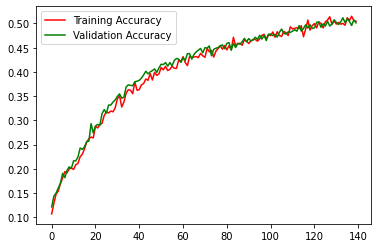

In [ ]:
plt.plot(history["Training Accuracy"], label="Training Accuracy", color="red")
plt.plot(history["Validation Accuracy"], label="Validation Accuracy", color="green")
plt.legend()
plt.show()

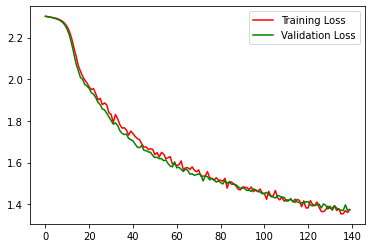

In [ ]:
plt.plot(history["Training Loss"], label="Training Loss", color="red")
plt.plot(history["Validation Loss"], label="Validation Loss", color="green")
plt.legend()
plt.show()

#Heatmap

In [ ]:
classes = trainset.dataset.classes
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)

In [ ]:
import seaborn as sns
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for k in range(len(labels)):
            true_label = labels[k].item()
            predicted_label = predicted[k].item()
            heatmap.iloc[true_label,predicted_label] += 1

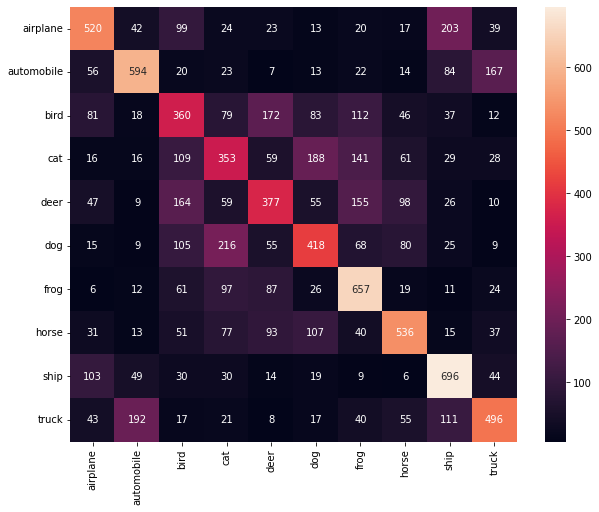

In [ ]:
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d")
plt.show()

#Comparison with part 1a
In part 1a, our model achieved around 57% accuracy on test dataset, but with this augmented dataset, it has achieved around 50% accuracy. So the performance certainly dropped a bit. This is because this simple CNN architecture cannot handle the augmentated images with rotations and flips. Ideally, the performance of model trained on augmented dataset should be more robust. Without the GPU runtime constraint, I definitely could have tweaked the model more and achieved better performance. 

Dataset: Cifar10 https://pytorch.org/vision/stable/datasets.html \\
References: 
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html 
- https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html 
- https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html 
- https://pytorch.org/vision/stable/transforms.html